<a href="https://colab.research.google.com/github/emish8/Converting-Photos-to-Monet-Style-Paintings-Using-GANs/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Neural Style Transfer to Convert Photo to Monet Style Painting

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import cv2

In [3]:
!pip install kaggle
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!echo "KAGGLE_USERNAME=emish8" >> .env
!echo "KAGGLE_KEY=527d479f0f0eee6101da45b8ddf0872b" >> .env

In [5]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# Fill in your user name and key from creating the kaggle account and API token file

import json
from dotenv import dotenv_values

CONFIG = dotenv_values('.env')

kaggle_username = CONFIG['KAGGLE_USERNAME']
kaggle_key = CONFIG['KAGGLE_KEY']

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [7]:
! kaggle competitions download -c gan-getting-started

!unzip -o  gan-getting-started.zip &> /dev/null 

 96% 353M/367M [00:03<00:00, 156MB/s]
100% 367M/367M [00:03<00:00, 125MB/s]


In [8]:
import glob
def read_filenames(path):
  path = path + '*.jpg'
  names = glob.glob(path)
  return names

In [9]:
def display_image(num, row, filenames):

  plt.figure(figsize=(num,num))
  
  for i in range(num):
    img = cv2.imread(filenames[i])
    image =  cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    ax = plt.subplot(row, row, i + 1) 
    plt.imshow(image)
    plt.axis("off")
  
  return 

No. of monet images in jpg format: 300


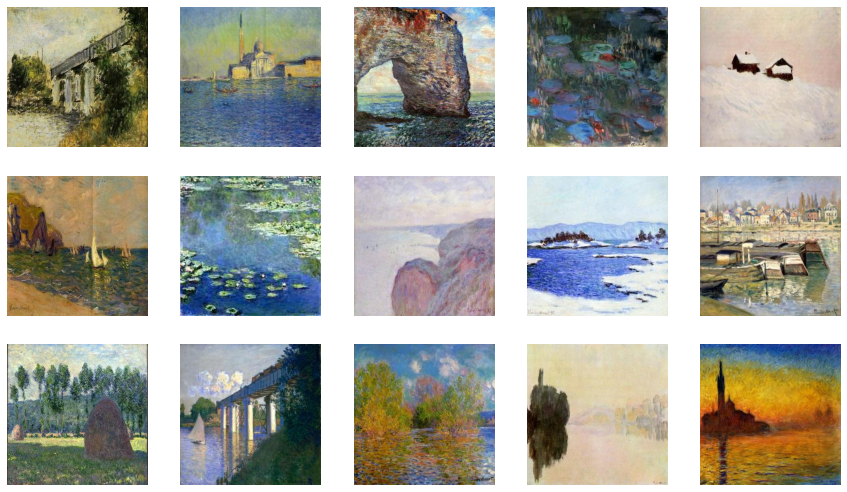

In [10]:
# sample from monet image dataset
monet_path = '/content/monet_jpg/'
monet_filenames = read_filenames(monet_path)
print('No. of monet images in jpg format:', len(monet_filenames))
display_image(15,5, monet_filenames)

No. of images in photo set: 7038


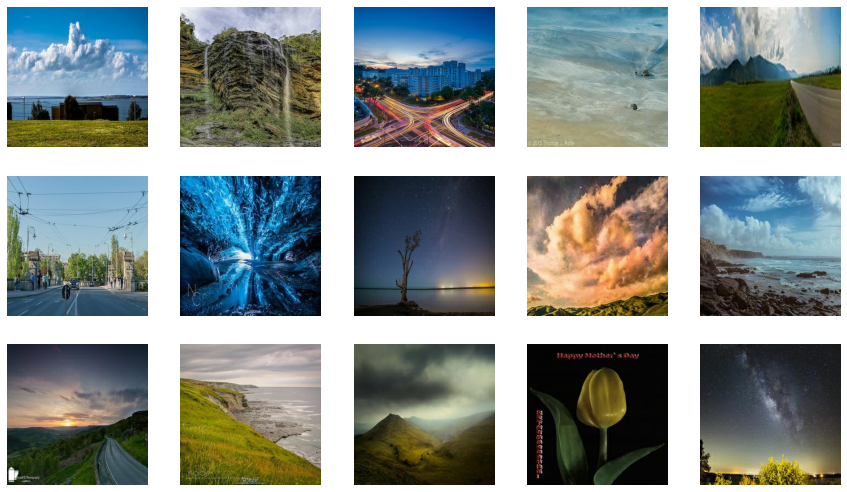

In [11]:
# sample from photo dataset
photo_path = '/content/photo_jpg/'
photo_filenames = read_filenames(photo_path)
print('No. of images in photo set:', len(photo_filenames))
display_image(15,5, photo_filenames)

In [38]:
def read_img(path):
  img = cv2.imread(path)
  img =  cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

  return img


In [42]:
def display_inputs(content_path, style_path):
  print(content_path, style_path)
  content_img = read_img(content_path)
  style_img = read_img(style_path)

  plt.subplot(1,2,1).set_title('Content Image'), plt.imshow(content_img),  plt.axis('off')
  plt.subplot(1,2,2).set_title('Style Image'), plt.imshow(style_img),  plt.axis('off')

 

/content/photo_jpg/304c2f4d34.jpg /content/monet_jpg/89d970411d.jpg


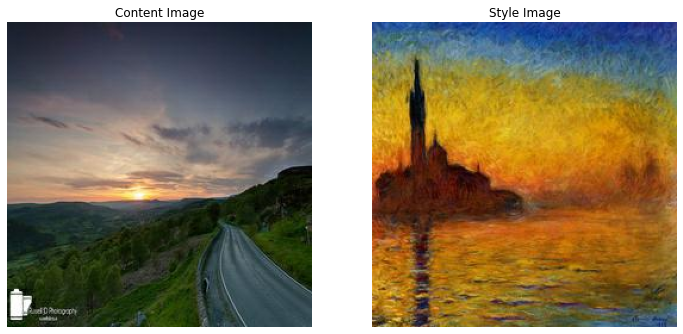

In [70]:
display_inputs(photo_filenames[10], monet_filenames[14]);

In [53]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [63]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [62]:
content_image =  load_img(photo_filenames[10])
style_image = load_img(monet_filenames[14])

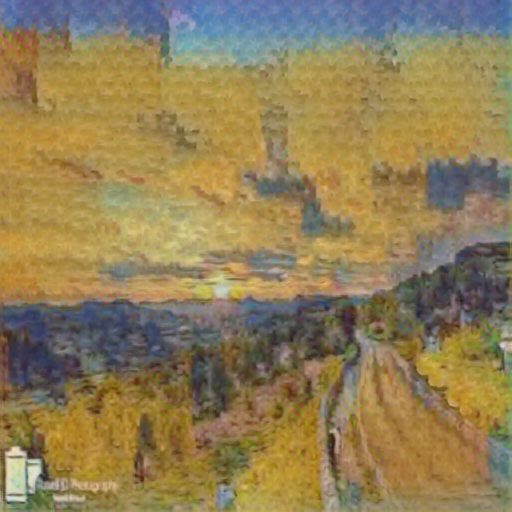

In [65]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [66]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [67]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


35363/35363 [==============================] - 0s 0us/step


[('mountain_tent', 0.82654965),
 ('valley', 0.070750706),
 ('alp', 0.046507414),
 ('lakeside', 0.012261598),
 ('cliff', 0.006925108)]

In [68]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 0s 0us/step

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [71]:
#choosing intermediate layers 
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [75]:
print('number of style layers',num_content_layers) 
print('number of style layers',num_style_layers )

number of style layers 1
number of style layers 5


In [76]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [77]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  567.35364
  mean:  32.023468

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  3071.6147
  mean:  122.890434

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  6654.923
  mean:  99.75795

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  12791.575
  mean:  406.21854

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  1691.589
  mean:  27.02972



In [80]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [81]:
# This returns gram matrix of style and content layers

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [82]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0010047919
    max:  22594.41
    mean:  272.39233

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  29515.146
    mean:  5479.3784

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  172085.75
    mean:  4758.986

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1669805.1
    mean:  79382.19

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  36068.348
    mean:  486.16513

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  850.7115
    mean:  7.561421


In [83]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [84]:
image = tf.Variable(content_image)

In [85]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [86]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [87]:
style_weight=1e-2
content_weight=1e4

In [88]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [89]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

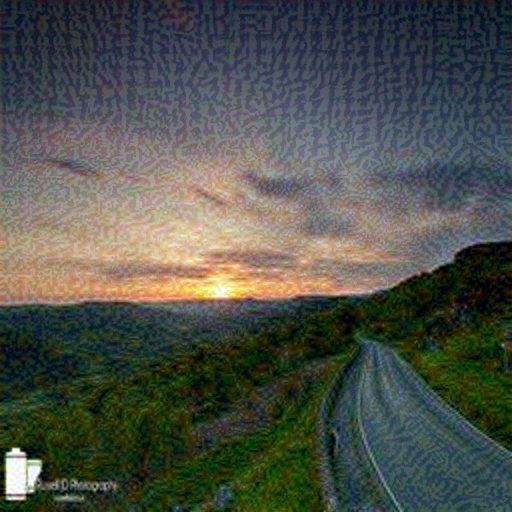

In [90]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

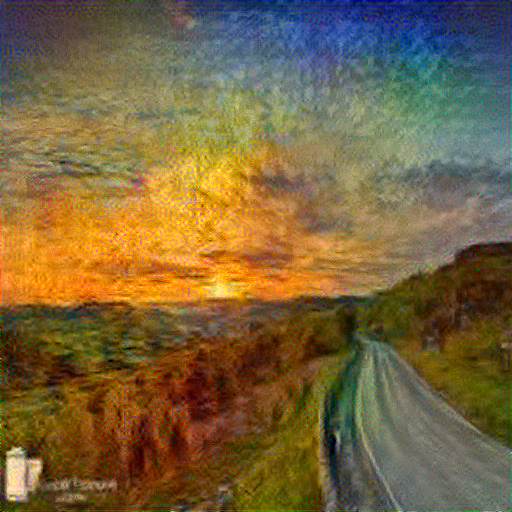

Train step: 1000
Total time: 95.9


In [91]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [92]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

(-0.5, 510.5, 511.5, -0.5)

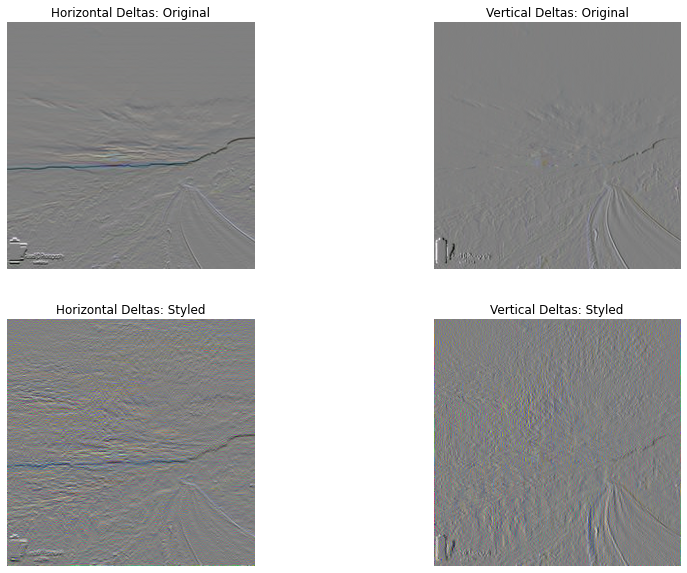

In [107]:
x_deltas, y_deltas = high_pass_x_y(content_image)
from matplotlib.pyplot import * 


plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1).set_title("Horizontal Deltas: Original")
i = clip_0_1(2*y_deltas+0.5)[0]
plt.imshow(i)
plt.axis('off')

plt.subplot(2, 2, 2).set_title("Vertical Deltas: Original")
i = clip_0_1(2*x_deltas+0.5)[0]
plt.imshow(i) 
plt.axis('off')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3).set_title("Horizontal Deltas: Styled")
i = clip_0_1(2*y_deltas+0.5)[0]
plt.imshow(i)
plt.axis('off')

plt.subplot(2, 2, 4).set_title("Vertical Deltas: Styled")
i = clip_0_1(2*x_deltas+0.5)[0]
plt.imshow(i)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

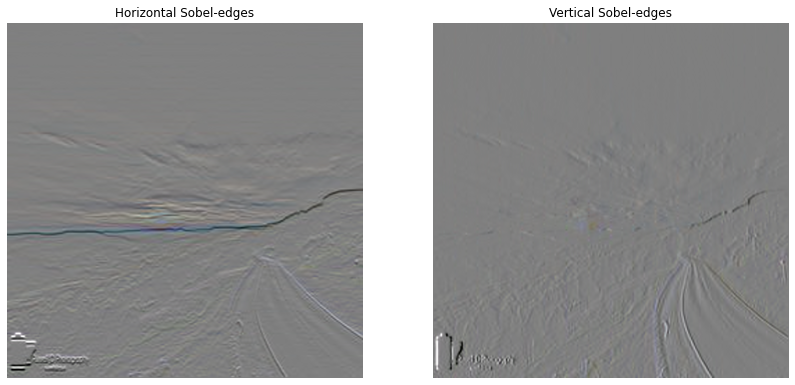

In [110]:
#doing same using sobel
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1).set_title("Horizontal Sobel-edges")
i = clip_0_1(sobel[..., 0]/4+0.5)[0]
plt.imshow(i)
plt.axis('off')


plt.subplot(1, 2, 2).set_title( "Vertical Sobel-edges")
i = clip_0_1(sobel[..., 1]/4+0.5)[0]
plt.imshow(i)
plt.axis('off')

In [111]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [112]:
total_variation_loss(image).numpy()

80930.32

In [113]:
total_variation_weight=30

In [114]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [115]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [116]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

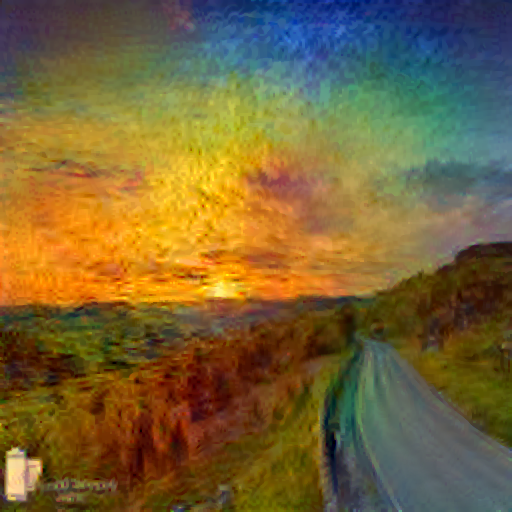

Train step: 1000
Total time: 97.5


In [117]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [118]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>